In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras_tuner.tuners import Hyperband
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# Ensuring GPU acceleration is active
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Defining a function that is used when loading/processing the image data
def preprocess_image(image_path, bbox):
    """Loads an image, crops it to the bounding box, resizes it, and normalizes it."""
    img = cv2.imread(image_path)
    img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

In [5]:
# 1. Load and preprocess the training data

# Load the CSV files
df_train = pd.read_csv("Data/annotations_train_grouped.csv")
df_grouped = pd.read_csv("Data/class_names_manufacturer_country_region_grouped.csv")

# Create a dictionary mapping class indices to class names
class_names = {index: row["manufacturer"] for index, row in df_grouped.iterrows()}

# File paths to save the preprocessed data
x_train_path = "Data/x_train.npy"
y_train_path = "Data/y_train.npy"

# Check if preprocessed data exists
if os.path.exists(x_train_path) and os.path.exists(y_train_path):
    # Load the preprocessed data
    x_train = np.load(x_train_path)
    y_train = np.load(y_train_path)
else:
    # Load and preprocess the training data
    x_train = []
    y_train = []
    for i, row in df_train.iterrows():
        image_path = f"Data/cars_train/{row['fname'].split('/')[-1]}"
        bbox = [row['bbox_x1'], row['bbox_y1'], row['bbox_x2'], row['bbox_y2']]
        x_train.append(preprocess_image(image_path, bbox))
        y_train.append(row["class"])

    # Convert the data to NumPy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Save the preprocessed data
    np.save(x_train_path, x_train)
    np.save(y_train_path, y_train)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [ ]:
#2. Defining multiple models to explore various approaches

def create_model(
    num_conv_layers=3,
    filters_per_layer=64,
    optimizer="adam",
    learning_rate=0.001,
    dropout_rate=0.5,
    use_early_stopping=True,
):
    """Creates and compiles a CNN model with the specified parameters."""

    model = keras.Sequential()
    model.add(keras.Input(shape=(224, 224, 3)))

    for i in range(num_conv_layers):
        model.add(
            layers.Conv2D(
                filters_per_layer * 2**i, kernel_size=(3, 3), activation="relu"
            )
        )
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(49, activation="softmax"))

    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )

    return model

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Define the models with different parameters
models = [
    {
        "name": "model_1",
        "num_conv_layers": 3,
        "filters_per_layer": 32,
        "optimizer": "adam",
        "learning_rate": 0.001,
        "dropout_rate": 0.5,
        "use_early_stopping": True,
        "epochs": 50,
    },
    {
        "name": "model_2",
        "num_conv_layers": 4,
        "filters_per_layer": 32,
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "dropout_rate": 0.5,
        "use_early_stopping": True,
        "epochs": 50,
    },
    {
        "name": "model_3",
        "num_conv_layers": 3,
        "filters_per_layer": 64,
        "optimizer": "rmsprop",
        "learning_rate": 0.001,
        "dropout_rate": 0.5,
        "use_early_stopping": True,
        "epochs": 50,
    },
    {
        "name": "model_4",
        "num_conv_layers": 4,
        "filters_per_layer": 64,
        "optimizer": "rmsprop",
        "learning_rate": 0.0001,
        "dropout_rate": 0.5,
        "use_early_stopping": True,
        "epochs": 50,
    },
    {
        "name": "model_5",
        "num_conv_layers": 3,
        "filters_per_layer": 32,
        "optimizer": "sgd",
        "learning_rate": 0.001,
        "dropout_rate": 0.5,
        "use_early_stopping": True,
        "epochs": 50,
    },
    {
        "name": "model_6",
        "num_conv_layers": 4,
        "filters_per_layer": 32,
        "optimizer": "sgd",
        "learning_rate": 0.0001,
        "dropout_rate": 0.5,
        "use_early_stopping": True,
        "epochs": 50,
    },
    {
        "name": "model_7",
        "num_conv_layers": 3,
        "filters_per_layer": 64,
        "optimizer": "adam",
        "learning_rate": 0.001,
        "dropout_rate": 0.25,
        "use_early_stopping": False,
        "epochs": 50,
    },
    {
        "name": "model_8",
        "num_conv_layers": 4,
        "filters_per_layer": 64,
        "optimizer": "rmsprop",
        "learning_rate": 0.0001,
        "dropout_rate": 0.25,
        "use_early_stopping": False,
        "epochs": 50,
    },
    {
        "name": "model_9",
        "num_conv_layers": 5,
        "filters_per_layer": 32,
        "optimizer": "sgd",
        "learning_rate": 0.001,
        "dropout_rate": 0.25,
        "use_early_stopping": False,
        "epochs": 50,
    },
    {
        "name": "model_10",
        "num_conv_layers": 4,
        "filters_per_layer": 16,
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "dropout_rate": 0.5,
        "use_early_stopping": True,
        "epochs": 100,
    },
]


In [ ]:
#First Attempt at using a pre-trained model

base_model = VGG16(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(49, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
)

# Save the trained model
model.save("pre_trained_vgg16_model.keras")

In [8]:
# Second attempt to use a pre-trained model
# Load the pretrained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(49, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=["accuracy"]
)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Implement early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save("fine_tuned_vgg16_model.keras")


Epoch 1/50
204/204 [==============================] - 30s 144ms/step - loss: 3.9259 - accuracy: 0.0783 - val_loss: 3.7467 - val_accuracy: 0.1068 - lr: 1.0000e-04
Epoch 2/50
204/204 [==============================] - 31s 150ms/step - loss: 3.7308 - accuracy: 0.0867 - val_loss: 3.6163 - val_accuracy: 0.1111 - lr: 1.0000e-04
Epoch 3/50
204/204 [==============================] - 29s 141ms/step - loss: 3.5912 - accuracy: 0.1131 - val_loss: 3.4426 - val_accuracy: 0.1657 - lr: 1.0000e-04
Epoch 4/50
204/204 [==============================] - 31s 149ms/step - loss: 3.3857 - accuracy: 0.1590 - val_loss: 3.0818 - val_accuracy: 0.2308 - lr: 1.0000e-04
Epoch 5/50
204/204 [==============================] - 28s 138ms/step - loss: 3.0694 - accuracy: 0.2301 - val_loss: 2.8846 - val_accuracy: 0.2879 - lr: 1.0000e-04
Epoch 6/50
204/204 [==============================] - 28s 137ms/step - loss: 2.7938 - accuracy: 0.3007 - val_loss: 2.4002 - val_accuracy: 0.3646 - lr: 1.0000e-04
Epoch 7/50
204/204 [========

In [ ]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Hyperparameter tuning function
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(224, 224, 3)))
    for i in range(hp.Int('num_conv_layers', 3, 6)): 
        model.add(layers.Conv2D(
            filters=hp.Int('filters_' + str(i), min_value=32, max_value=128, step=32),  
            kernel_size=hp.Choice('kernel_size_' + str(i), values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(hp.Float('dropout', 0.25, 0.5, step=0.1)))  
    model.add(layers.Dense(len(class_names), activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')), 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='keras_tuner',
    project_name='Car-Manufacturer-Recognition-using-CNNs'
)

tuner.search_space_summary()

tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             epochs=10,
             validation_data=(x_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Train the best model with the entire dataset
history = best_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val)
)

best_model.save("best_model.keras")


In [ ]:
# 3. Train models

# Train the models
for model_params in models:
    print(f"Training {model_params['name']}...")
    model = create_model(
        num_conv_layers=model_params["num_conv_layers"],
        filters_per_layer=model_params["filters_per_layer"],
        optimizer=model_params["optimizer"],
        learning_rate=model_params["learning_rate"],
        dropout_rate=model_params["dropout_rate"],
        use_early_stopping=model_params["use_early_stopping"],
    )

    callbacks = []
    if model_params["use_early_stopping"]:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
        callbacks.append(early_stopping)

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        epochs=model_params["epochs"],
        validation_data=(x_val, y_val),
        callbacks=callbacks,
    )

    # Save the trained model
    model.save(f"{model_params['name']}.keras")

In [ ]:
#Save the model for future use
model.save("original_model.keras")

In [ ]:
#Reload the model
model = keras.models.load_model("original_model.keras")

In [4]:
# 4. Load and preprocess the test data

# Load the CSV files
df_test = pd.read_csv("Data/annotations_test_grouped.csv")
df_grouped = pd.read_csv("Data/class_names_manufacturer_country_region_grouped.csv")

# Create a dictionary mapping class indices to class names
class_names = {index: row["manufacturer"] for index, row in df_grouped.iterrows()}

# File paths to save the preprocessed data
x_test_path = "Data/x_test.npy"
y_test_path = "Data/y_test.npy"

# Check if preprocessed data exists
if os.path.exists(x_test_path) and os.path.exists(y_test_path):
    # Load the preprocessed data
    x_test = np.load(x_test_path)
    y_test = np.load(y_test_path)
else:
    # process the data
    x_test = []
    y_test = []
    for i, row in df_test.iterrows():
        image_path = f"Data/cars_test/{row['fname'].split('/')[-1]}"
        bbox = [row['bbox_x1'], row['bbox_y1'], row['bbox_x2'], row['bbox_y2']]
        x_test.append(preprocess_image(image_path, bbox))
        y_test.append(row["class"])

    # Convert the data to NumPy arrays
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Save the preprocessed data
    np.save(x_test_path, x_test)
    np.save(y_test_path, y_test)
    
# Create a smaller test set due to an issue when running the full fat dataset for evaluation
x_test_small, _, y_test_small, _ = train_test_split(
    x_test, y_test, test_size=0.33, random_state=42, stratify=y_test
)

In [7]:
#Testing a particular model
model = keras.models.load_model("fine_tuned_vgg16_model.keras")

try:
    # Evaluate the model on the smaller test set
    loss, accuracy = model.evaluate(x_test_small, y_test_small)
    print("Test accuracy (small set):", accuracy)

except Exception as e:
    print(f"An error occurred during evaluation: {e}")
    import traceback
    traceback.print_exc()

169/169 [==============================] - 4s 24ms/step - loss: 0.3548 - accuracy: 0.9393
Test accuracy (small set): 0.9392982721328735


In [ ]:
# 4. Evaluate the model

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)

In [ ]:
# 4. Evaluate all of the models with a slightly reduced size due to kernel crashing when I ran the entire dataset, not sure why and I couldn't fix it
model_names = [f"model_{i}.keras" for i in range(1, 11)]
results = []

for model_name in model_names:
    try:
        model = keras.models.load_model(model_name)
        loss, accuracy = model.evaluate(x_test_small, y_test_small)
        results.append({"model_name": model_name, "accuracy": accuracy})
    except Exception as e:
        print(f"An error occurred while evaluating {model_name}: {e}")

# Print the results in a formatted table
print("-" * 40)
print("Model\t\tAccuracy")
print("-" * 40)
for result in results:
    print(f"{result['model_name']}\t{result['accuracy']:.4f}")
print("-" * 40)

204/204 [==============================] - 1s 3ms/step


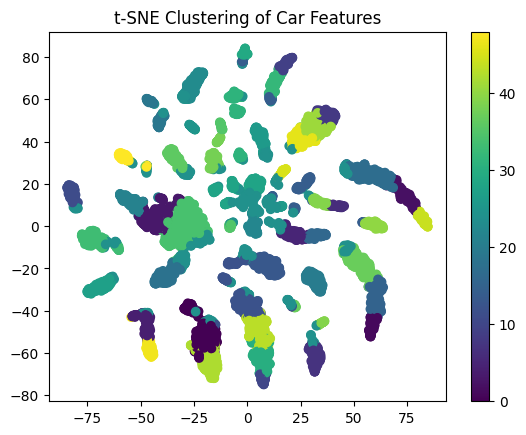

In [9]:
# Load the desired model for visualization
model_to_visualize = keras.models.load_model("fine_tuned_vgg16_model.keras") #replace with model you want!

# Create a feature extractor model
feature_extractor = keras.Model(inputs=model_to_visualize.input,
                                outputs=model_to_visualize.get_layer(index=-2).output)

# Extract features for the training data
features = feature_extractor.predict(x_train)

# Reduce dimensionality using PCA
pca = PCA(n_components=50)
pca_features = pca.fit_transform(features)

# Further reduce dimensionality using t-SNE for visualization
tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(pca_features)

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=len(class_names))
clusters = kmeans.fit_predict(pca_features)

# Plot the t-SNE features with clustering results
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Clustering of Car Features')
plt.show()
